## Simple Linear Regresion

### Requirement: Need to predict the diamonds price based on the independent variable using regression model. 
As part of this exercise, I've cross across the unsual cross validtion results of the model despite there was no data leakage. I have addressed this issue in model evaluation section which is last section of the notebook.

In [1]:
# import libraries required for this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Data Collection

In [2]:
# Read the csv file data from URL 
raw_dataset_url="https://raw.githubusercontent.com/mwaskom/seaborn-data/master/diamonds.csv"
df_diamonds=pd.read_csv(raw_dataset_url)
df_diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Data Preprocessing


Let's rename the columns in the dataframe

In [3]:
lcase_cols=df_diamonds.columns.to_list()
cap_cols=[col.capitalize() for col in lcase_cols]
df_diamonds.columns=cap_cols

df_diamonds.rename(columns={'X':'Length', 'Y':'Width', 'Z':'Height'}, inplace=True)
df_diamonds.head()

,Carat,Cut,Color,Clarity,Depth,Table,Price,Length,Width,Height
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
df_diamonds.dtypes

Carat      float64
Cut         object
Color       object
Clarity     object
Depth      float64
Table      float64
Price        int64
Length     float64
Width      float64
Height     float64
dtype: object


Missing values check - None of the columns in the dataframe has null or NaN values.

In [5]:
df_diamonds.isnull().sum().to_frame().T  # No Null values

,Carat,Cut,Color,Clarity,Depth,Table,Price,Length,Width,Height
0,0,0,0,0,0,0,0,0,0,0


#### Pearson corelation summary
Let's create a summary dataframe for pearson coefficients and p-values to select the best independent variable for the linear model

In [6]:
from scipy.stats import pearsonr

pearson_coeff=[]
pearson_pval=[]

numerical_var=df_diamonds.select_dtypes(exclude='object').columns

for col in numerical_var:
    coef_, pval_=pearsonr(df_diamonds[col], df_diamonds['Price'])
    pearson_coeff.append(coef_)
    pearson_pval.append(pval_)

df_pearson_stats=pd.DataFrame({'Coeff':pearson_coeff, 'P_val':pearson_pval}, index=numerical_var)
df_pearson_stats.round(3).sort_values(by='Coeff', ascending=False)

,Coeff,P_val
Price,1.000,0.000
Carat,0.922,0.000
Length,0.884,0.000
Width,0.865,0.000
Height,0.861,0.000
Table,0.127,0.000
Depth,-0.011,0.013



Clearly the 'Carat' feature is highly correlated with target variable i.e. price with pretty high coefficient that too p-value (rounded value) returns almost 100% confidence level. So, we will use this feature as input variable (Price = W1 * Carat + b) and let's see how good the model will be 

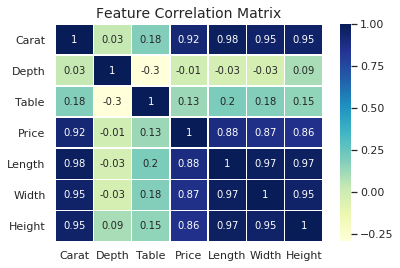

In [7]:
# Create a heatamp to see pari-wise correlation 
df_heatmap=df_diamonds.corr()
hmap_values=df_heatmap.round(2).values

plt.figure(figsize=(6,4))
ax=sns.heatmap(df_heatmap, annot=hmap_values, cmap='YlGnBu', linewidths=0.3)

## Matplotlib exising version is truncating the y-axis edges. 
# so, manually adjusting the y limits
y_min, y_max=ax.get_ylim()
plt.ylim(y_min+0.5, y_max-0.5)

plt.title("Feature Correlation Matrix", fontsize='14')
plt.show()


Data summary:

In [8]:
df_diamonds.describe()

,Carat,Depth,Table,Price,Length,Width,Height
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000



From the above stats summary, we can see that there is high difference between the upper quartile and max values of 'Carat' & 'Price'. Let's see the distribution plots for both the features

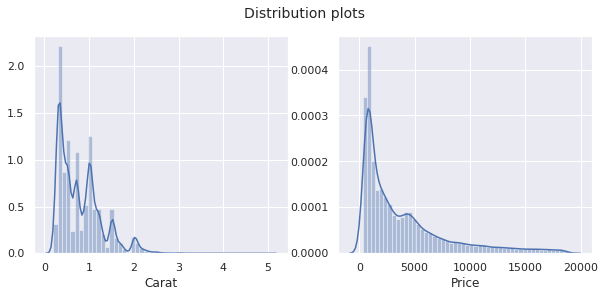

In [9]:
rows, cols=1, 2
cols_list=['Carat', 'Price']

fig, subaxes = plt.subplots(rows, cols, figsize=(10,4))
fig.suptitle("Distribution plots", fontsize=14)

for ax, col in zip(subaxes, cols_list):
    sns.distplot(df_diamonds[col], ax=ax)
    ax.set_xlabel(col)    
    
plt.show()

#### Handling Ouliers in 'Carat' feature
Since we have the outliers and it may cause an impact on the model, we are going to remove the top 1% quantile values from the dataset

In [10]:
Carat_outliers=df_diamonds['Carat'].quantile(0.99)
df_transform=df_diamonds[df_diamonds['Carat']<=Carat_outliers]

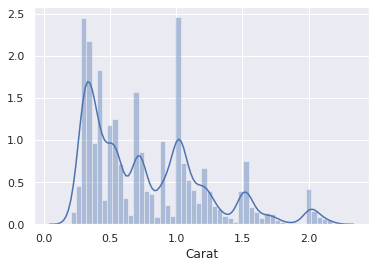

In [11]:
sns.distplot(df_transform['Carat'])
plt.show()


Now we can see the above Carat feature distribution looks better. Let's see the scatter plot for both the variables

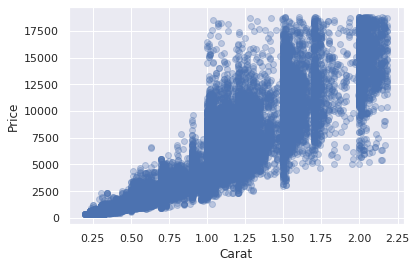

In [12]:
plt.scatter(df_transform['Carat'], df_transform['Price'], alpha=0.3)
plt.xlabel('Carat')
plt.ylabel('Price')
plt.show()

In [13]:
# Create a variables for both dependent and independent feature
X=df_transform[['Carat']]
y=df_transform['Price']
X.shape, y.shape

((53424, 1), (53424,))

## Linear Regression
Now the dataset is ready to feed the linear regression model. Let's split the 70:30 data into train and test datasets respectively

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((37396, 1), (37396,), (16028, 1), (16028,))


Using the training set that we have created above, we are going to train the model and we will keep the test dataset aside for now to check the model performance later for unseen data. 

In [15]:
from sklearn.linear_model import LinearRegression
linear_reg=LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [16]:
# model weighted coefficients and intercept/slope
linear_reg.coef_, linear_reg.intercept_

(array([7906.28956938]), -2355.8836026061795)

In [17]:
# predict some price values
linear_reg.predict(X_train[0:10])

array([13535.75843185,  6103.84623663,  5945.72044524,    95.0661639 ,
        5629.46886247,   885.69512084,  9582.61364716,  6973.53808926,
        7131.66388065,  4680.71411414])

### Model Evaluation
Now the model is ready to predict the values, let's evaluate the test dataset score

In [18]:
train_score=linear_reg.score(X_train, y_train)
test_score=linear_reg.score(X_test, y_test)
print ("Training score:{:.2f}  Testing score:{:.2f}".format(train_score, test_score))

Training score:0.85  Testing score:0.85


#### Residuals Distribution plot


We have obtained the descent train and test scores, however we will do further checks for possibilities of model improvement. Let's see the distribution plot for difference between actual target values and predicted values

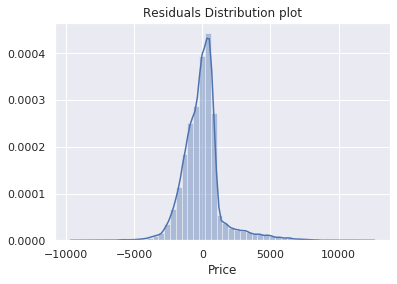

In [19]:
yhat_lr=linear_reg.predict(X_test)
np.mean(y_test - yhat_lr)

sns.distplot(y_test - yhat_lr)
plt.title("Residuals Distribution plot")
plt.show()


From the above plot, we can see that the mean of residuals is zero which is one the assumptions for Linear regression. Now, we will create the visualization for linear model fit line 

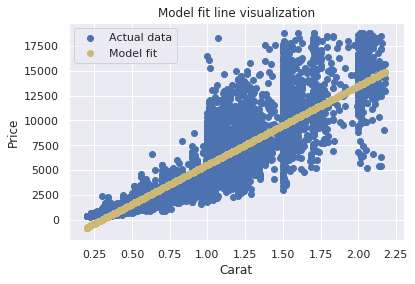

In [20]:
plt.scatter(X_test, y_test, color='b', label='Actual data')
plt.scatter(X_test, yhat_lr, color='y', label='Model fit')

plt.xlabel('Carat')
plt.ylabel('Price')
plt.title('Model fit line visualization')
plt.legend()
plt.show()

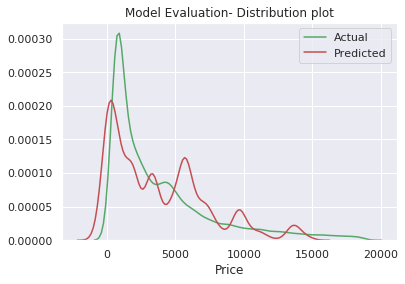

In [21]:
sns.distplot(y_train, color='g', hist=False, label='Actual')
sns.distplot(linear_reg.predict(X_train), color='r', hist=False, label='Predicted')
plt.title("Model Evaluation- Distribution plot")
plt.legend()
plt.show()


The model seems to be overfit as we can clearly see that the predicted values are having fluctuations relative to the Actual target values. Looks like we need to refine the model to produce better results. 

### Cross Validation

In [22]:
from sklearn.model_selection import cross_val_score
cval=cross_val_score(linear_reg, X, y, cv=4)
print ("Cross validation scores:", cval)

Cross validation scores: [-0.75769159  0.45668974  0.84060225 -1.10182941]


Clearly the above numbers doesn't look good at all. Looks like something went wrong as we can see the cross validation scores are incorrect. This is because the input data is in sorted order and the folds that cross validation considers are biased with full variance. Let's prove this hypothesis by not shuffling the dataset

In [23]:
from sklearn.model_selection import cross_val_score
X_, _, y_, _ = train_test_split(X, y, test_size=0.0, random_state=27, shuffle=False)  # without shuffle
cval=cross_val_score(linear_reg, X_, y_, cv=4)
print ("Cross validation scores:", cval)

Cross validation scores: [-0.75769159  0.45668974  0.84060225 -1.10182941]


Excellent! Now it is evident that dataset is sorted and therefore cross validation is producing the biased results. Let's shuffle the input dataset and apply the Cross validation to check the overall model performance 

In [24]:
from sklearn.model_selection import cross_val_score
X_, _, y_, _ = train_test_split(X, y, test_size=0.0, random_state=27, shuffle=True) # shuffle the dataset
cval=cross_val_score(linear_reg, X_, y_, cv=4)
print ("Cross validation scores:", cval)
print ("Average model accuracy:{:.2f}".format(np.mean(cval)))

Cross validation scores: [0.84586401 0.84458235 0.84816024 0.84563191]
Average model accuracy:0.85


### Conclusion

We have got the descent overall accuracy score from cross validation i.e. 85%. However, we have noticed in the model evaluation distribution plot that model still needs to be tuned further to produce accurate results with good model complexity. 